In [1]:
#!/usr/bin/env python
# coding: utf-8

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
## Print multiple output per cell,
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [4]:
## Importing libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [5]:
## Pandas Display options
pd.set_option('display.max_columns',0)
pd.set_option('display.max_colwidth',0)

In [6]:
## Reading relevant data
match_lvl_data = pd.read_csv('/content/drive/MyDrive/AMEX/match_level_scorecard.csv')
batsman_lvl_data = pd.read_csv('/content/drive/MyDrive/AMEX/batsman_level_scorecard.csv')
bowler_lvl_data = pd.read_csv('/content/drive/MyDrive/AMEX/bowler_level_scorecard.csv')
train_data = pd.read_csv('/content/drive/MyDrive/AMEX/train_data_with_samplefeatures.csv')
test_data = pd.read_csv('/content/drive/MyDrive/AMEX/test_data_with_samplefeatures.csv')

# Printing shape and sample rows of each dataset

In [7]:
match_lvl_data.shape
match_lvl_data.head(2)

(1689, 30)

,match id,team1,team2,winner,by,win amount,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,umpire1,umpire2,inning1_runs,inning1_wickets,inning1_balls,inning2_runs,inning2_wickets,inning2_balls,team1_id,team1_roster_ids,team2_id,team2_roster_ids,series_type,winner_id,player_of_the_match_id
0,8638034,Nn Ds,Wn,Wn,wickets,9.0,Wn,field,By Ol,Mount Maunganui,2021-01-01,night match,Sr Sh,2020/21,17681,Dn Mw,TJ Pe,148,6,130,152.0,1.0,97.0,17982,7907451.0:4381761.0:31464.0:258649.0:4949790.0:3834305.0:3776849.0:6718340.0:3566240.0:4950364.0:7543647.0,18570,2653993.0:6718326.0:6718382.0:2486896.0:2288789.0:4950224.0:8187878.0:3083667.0:4950294.0:6718396.0:1585464.0,other_domestic,18570,NaN
1,8588005,Me Rs,Sy Tr,Sy Tr,runs,7.0,Sy Tr,field,Ca Ol,Carrara,2021-01-01,night match,Bg Bh Le,2020/21,6663,D Tr,PJ Ge,166,6,106,117.0,2.0,74.0,33942,37351.0:46794.0:5406540.0:2231928.0:181404.0:1594319.0:7534687.0:7537067.0:1905847.0:8339701.0:7620346.0,33963,1506098.0:1749075.0:36665.0:2083409.0:7534652.0:5788320.0:1612610.0:5509524.0:5497274.0:3876613.0:8193310.0,other_domestic,33963,1749075.0


In [8]:
batsman_lvl_data.shape
batsman_lvl_data.head(2)

(24483, 21)

,match id,batsman,batsman_id,batsman_details,is_batsman_captain,is_batsman_keeper,inning,runs,balls_faced,over_faced_first,wicket kind,out_by_bowler,out_by_fielder,bowler_id,bowler_details,is_bowler_keeper,is_bowler_captain,strike_rate,Fours,Sixes,match_dt
0,8638034,KD Ce,7907451.0,NZ:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,7,5,1.1,caught,JS Nm,TM Jn,2486896.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,140.0,1.0,NaN,2021-01-01
1,8638034,TL St,4381761.0,NZ:Right-hand bat:None:,0.0,1.0,1,46,46,1.2,caught,R Ra,MG Bl,6718382.0,NZ:Left-hand bat:Slow left-arm orthodox:,0.0,0.0,100.0,4.0,1.0,2021-01-01


In [9]:
bowler_lvl_data.shape
bowler_lvl_data.head(2)

(18539, 18)

,match id,bowler,bowler_id,bowler_details,is_bowler_captain,is_bowler_keeper,inning,runs,wicket_count,balls_bowled,economy,maiden,dots,Fours,Sixes,wides,noballs,match_dt
0,8638034,BV Ss,6718396.0,NZ:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,21,0,12,10.5,0,3.0,1,1,3,1,2021-01-01
1,8638034,HK Bt,1585464.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,1,34,1,24,8.5,0,7.0,3,1,2,0,2021-01-01


In [10]:
train_data.shape
train_data.head(2)

(948, 23)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000


In [11]:
nan_count_per_column = train_data.isna().sum()
print("\nTotal NaN values per column:\n", nan_count_per_column)


Total NaN values per column:
 match id                     0 
team1                        0 
team1_id                     0 
team1_roster_ids             0 
team2                        0 
team2_id                     0 
team2_roster_ids             0 
winner                       0 
winner_id                    0 
toss winner                  0 
toss decision                0 
venue                        0 
city                         0 
match_dt                     0 
lighting                     0 
series_name                  0 
season                       0 
ground_id                    0 
team_count_50runs_last15     0 
team_winp_last5              0 
team1only_avg_runs_last15    21
team1_winp_team2_last15      0 
ground_avg_runs_last15       53
dtype: int64


In [12]:
train_data = train_data.dropna()
train_data = train_data.drop_duplicates()

# List of categorical columns to be one-hot encoded
# categorical_columns = [   ]

# # Apply one-hot encoding using pd.get_dummies
# encoded_train_data = pd.get_dummies(train_data, columns=categorical_columns)
def encode_lighting_value(value):
    if value == 'day/night match':
        return 0
    elif value == 'day match':
        return 1
    elif value == 'night match':
        return 2

train_data['lighting'] = train_data['lighting'].apply(encode_lighting_value)
test_data['lighting'] = test_data['lighting'].apply(encode_lighting_value)


train_data.head()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,0,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.000000,100.0,157.178571
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,0,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.000000,50.0,103.500000
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:3681957.0:7671313.0:5320118.0:2922611.0:7184232.0:7661996.0:6240632.0,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:5516720.0:7328110.0:125915.0:130437.0:7507303.0:4420828.0:5652828.0,We,10576,Ne,field,Tt Be Nm,Nottingham,2023-06-02,0,Vy Bt,2023,251,0.857143,0.672131,173.266667,0.0,154.333333
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:4690188.0:4739580.0:4739552.0:5744850.0:2294823.0:9266102.0:284339.0,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:5742470.0:2740408.0:3575774.0:3200756.0:334963.0:6399210.0:6347494.0,Ga An Ws,36084,Ga An Ws,bat,Bn La Sm Ta Td,Tarouba,2023-09-10,1,Cn Pr Le,2023,14300,2.166667,1.975610,164.266667,50.0,144.250000
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082.0:4640824.0:5038046.0:8180500.0:2035102.0:3851518.0:7881845.0:7453697.0,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:2252452.0:2966879.0:5554254.0:4690230.0:3373285.0:3759846.0:6496482.0,Gt Ts,48341,Gt Ts,field,Pb Ct An IS Ba Sm Mi Ch,Chandigarh,2023-04-13,2,In Pr Le,2023,7118,0.818182,1.327869,164.666667,0.0,189.000000


In [13]:
test_data.shape
test_data.head(2)

(271, 21)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9250275,Jy,28594,7438955.0:8271969.0:8369661.0:3685247.0:2590251.0:7785497.0:7785553.0:3296264.0:4613622.0:2904796.0:3685289.0,Ud Ss of Aa,90,2436944.0:8117500.0:6703528.0:3010748.0:1613870.0:8934764.0:2721480.0:1632819.0:2789604.0:6489846.0:1565507.0,Ud Ss of Aa,field,Bo Ac Cb,Bulawayo,2022-07-11,1,Ud Ss of Aa tr of Ze,2022,3226,0.000000,0.019608,NaN,0.00,NaN
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,2,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.5


In [14]:
test_data = test_data.dropna()
test_data.shape

(257, 21)

In [15]:
## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)


In [16]:

## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

In [17]:
# ## Code to plot RnP
!pip install seaborn
import seaborn as sns
sns.set()
sns.set(style="whitegrid")
from matplotlib import pyplot as plt
import re

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.

    Parameters-
    1. X_12: dataset to build the RnP on.
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.

    Output-
    1. Rank and Plot

    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();

In [18]:
# #### Helper function

# In[12]:


def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    '''
    Function to get last n games stats of a player before an input date.

    Input-
    1. player_id: id of the player to get historical data.
    2. date: date to look-back and get n games. Stats returned are before this input date.
    3. n: Number of historical games stats to return.
    4. bat_or_bowl: Kind of stats to return. {'bat': batting stats to return, 'bowl': bowling stats to return}

    Output-None

    Returns- dataframe having bowling/batting stats from last n games of a player before an input date.
    The results are sorted by date.
    '''
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'

    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)


In [19]:
def avgn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.

    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.

    Output-None

    Returns- int value denoting sum of 50s scored by all players in the roster.
    '''

    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting batting stats from last n games for each player.
        df_rel['Average'] = df_rel['runs'].mean() # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        res_list.append(np.nansum(df_rel['Average']))# Sum up number of 50s for the player and append to a list. We will do this for all players.
    return np.nansum(res_list)# Sum up values of the list which is sum of 50s by all players in the roster.

In [20]:
batsman_lvl_data = batsman_lvl_data.assign(PBA=0)
for i in range(len(batsman_lvl_data['batsman_id'])):
  batsman_lvl_data["PBA"][i] = giveLastNgamesPlayer(batsman_lvl_data['batsman_id'][i], batsman_lvl_data['match_dt'][i], 20, "bat")["runs"].mean()
batsman_lvl_data["PBA"] = batsman_lvl_data["PBA"].fillna(0)

<ipython-input-20-e5b757c89efa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batsman_lvl_data["PBA"][i] = giveLastNgamesPlayer(batsman_lvl_data['batsman_id'][i], batsman_lvl_data['match_dt'][i], 20, "bat")["runs"].mean()


In [21]:
batsman_lvl_data = batsman_lvl_data.assign(TBA=1)
batsman_lvl_data = batsman_lvl_data.assign(TBSR=1)
batsman_lvl_data["PBSR"] = batsman_lvl_data["runs"]/batsman_lvl_data["balls_faced"]

In [22]:
batsman_lvl_data.columns

Index(['match id', 'batsman', 'batsman_id', 'batsman_details',
       'is_batsman_captain', 'is_batsman_keeper', 'inning', 'runs',
       'balls_faced', 'over_faced_first', 'wicket kind', 'out_by_bowler',
       'out_by_fielder', 'bowler_id', 'bowler_details', 'is_bowler_keeper',
       'is_bowler_captain', 'strike_rate', 'Fours', 'Sixes', 'match_dt', 'PBA',
       'TBA', 'TBSR', 'PBSR'],
      dtype='object')

In [23]:
batsman_lvl_data.head()

,match id,batsman,batsman_id,batsman_details,is_batsman_captain,is_batsman_keeper,inning,runs,balls_faced,over_faced_first,wicket kind,out_by_bowler,out_by_fielder,bowler_id,bowler_details,is_bowler_keeper,is_bowler_captain,strike_rate,Fours,Sixes,match_dt,PBA,TBA,TBSR,PBSR
0,8638034,KD Ce,7907451.0,NZ:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,7,5,1.1,caught,JS Nm,TM Jn,2486896.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,140.00,1.0,NaN,2021-01-01,0.0,1,1,1.400000
1,8638034,TL St,4381761.0,NZ:Right-hand bat:None:,0.0,1.0,1,46,46,1.2,caught,R Ra,MG Bl,6718382.0,NZ:Left-hand bat:Slow left-arm orthodox:,0.0,0.0,100.00,4.0,1.0,2021-01-01,0.0,1,1,1.000000
2,8638034,HR Cr,4949790.0,NZ:Right-hand bat:Right-arm offbreak:,0.0,0.0,1,9,10,12.1,caught,PF Yd,R Ra,4950294.0,NZ:Right-hand bat:Legbreak googly:,0.0,0.0,90.00,NaN,NaN,2021-01-01,0.0,1,1,0.900000
3,8638034,BR Hn,3834305.0,NZ:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,28,22,13.6,caught,HK Bt,FH An,1585464.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,127.27,3.0,NaN,2021-01-01,0.0,1,1,1.272727
4,8638034,SC Kn,3776849.0,NZ:Right-hand bat:Right-arm fast-medium:,0.0,0.0,1,18,13,17.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.46,NaN,1.0,2021-01-01,0.0,1,1,1.384615


In [24]:
def batting_index(player_list, date, n):
  avg_index=0
  player_list = str(player_list).split(':')
  for player_id in player_list:
    df=giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
    # print(df.head())
    if not df.empty:
      PBA = df['runs'].mean()
      if(df['balls_faced'].sum()==0):
        PBSR=0
      else:
        PBSR = df['runs'].sum()/df['balls_faced'].sum()
      runs = df['runs'].sum()
      index = (PBA*runs + PBSR)*runs
      avg_index =avg_index+index
  return avg_index

In [25]:
# added by manvi
# function to return bowlers index
def bowler_index(player_list, date, n):
  avg_index=0
  delta= 10e5
  player_list = str(player_list).split(':')
  for player_id in player_list:
    df=giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bowl')
    # print(df.head())
    if not df.empty:
      total_balls_bowled_tbb= df['balls_bowled'].sum()+delta
      total_wickets_taken=df['wicket_count'].sum()+delta
      pbwer=(df['economy'].mean())*(df['economy'].mean())+delta
      index= (total_wickets_taken/total_balls_bowled_tbb + 1/pbwer)*total_wickets_taken
      avg_index = avg_index + index
      # print(index)
  return avg_index

In [26]:
print(batting_index("5959834.0:37351.0:4497646.0:1613919.0:4231702.0:1663885.0:1934099.0:3429236.0:8779896.0:2632825.0:7758638.0", "2022-04-15", 15))

30915728.767030172


In [27]:
batsman_lvl_data.head()

,match id,batsman,batsman_id,batsman_details,is_batsman_captain,is_batsman_keeper,inning,runs,balls_faced,over_faced_first,wicket kind,out_by_bowler,out_by_fielder,bowler_id,bowler_details,is_bowler_keeper,is_bowler_captain,strike_rate,Fours,Sixes,match_dt,PBA,TBA,TBSR,PBSR
0,8638034,KD Ce,7907451.0,NZ:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,7,5,1.1,caught,JS Nm,TM Jn,2486896.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,140.00,1.0,NaN,2021-01-01,0.0,1,1,1.400000
1,8638034,TL St,4381761.0,NZ:Right-hand bat:None:,0.0,1.0,1,46,46,1.2,caught,R Ra,MG Bl,6718382.0,NZ:Left-hand bat:Slow left-arm orthodox:,0.0,0.0,100.00,4.0,1.0,2021-01-01,0.0,1,1,1.000000
2,8638034,HR Cr,4949790.0,NZ:Right-hand bat:Right-arm offbreak:,0.0,0.0,1,9,10,12.1,caught,PF Yd,R Ra,4950294.0,NZ:Right-hand bat:Legbreak googly:,0.0,0.0,90.00,NaN,NaN,2021-01-01,0.0,1,1,0.900000
3,8638034,BR Hn,3834305.0,NZ:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,28,22,13.6,caught,HK Bt,FH An,1585464.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,127.27,3.0,NaN,2021-01-01,0.0,1,1,1.272727
4,8638034,SC Kn,3776849.0,NZ:Right-hand bat:Right-arm fast-medium:,0.0,0.0,1,18,13,17.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.46,NaN,1.0,2021-01-01,0.0,1,1,1.384615


In [28]:
# ## Feature creation

# ### 1. team_count_50runs_last15 <br>
# Ratio of number of 50s by players in team1 to number of 50s by players in team2 in last 15 games

# In[13]:


def no50sLastn(player_list, date, n):
    '''
    Function to get total number of 50s scored by players in the roster of a team in last n games.

    Input-
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.

    Output-None

    Returns- int value denoting sum of 50s scored by all players in the roster.
    '''

    player_list = str(player_list).split(':') # split string of ':' separated ids into a list of ids
    res_list = []
    for player in player_list: # loop over each player_id in roster
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') # getting batting stats from last n games for each player.
        df_rel['gte_50runs'] = np.where(df_rel['runs']>=50, 1, 0) # binary indicator to denote whether the player scored a 50 in the game (runs>=50).
        res_list.append(np.nansum(df_rel['gte_50runs']))# Sum up number of 50s for the player and append to a list. We will do this for all players.
    return np.nansum(res_list)# Sum up values of the list which is sum of 50s by all players in the roster.



In [29]:

# In[14]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
train_data['team1_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
# Computing number of 50 runs in last 15 games for team2 for train dataset.
train_data['team2_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


100%|██████████| 880/880 [00:34<00:00, 25.36it/s]


In [30]:
# In[15]:

# Taking ratio of (number of 50 runs in last 15 games for team1) to (number of 50 runs in last 15 games for team2). Adding 1 to handle divide by zero exceptions.
train_data['team_count_50runs_last15'] = (train_data['team1_count_50runs_last15']+1)/(train_data['team2_count_50runs_last15']+1)
train_data.drop(columns=['team1_count_50runs_last15','team2_count_50runs_last15'], inplace=True) # dropping intermediate columns


In [31]:
# In[16]:


train_data.shape
train_data.tail(2)


(880, 24)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:2125696.0:8228429.0:184960.0:3068547.0:3696482.0:8445478.0:3011735.0:6347494.0,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:4203499.0:5764576.0:8228408.0:4874820.0:8766603.0:7570107.0:2282125.0:5618038.0,Ss Hd,36014,Rn Rs,bat,Si Mh Sm Jr,Jaipur,2023-05-07,2,In Pr Le,2023,4661,0.789474,1.487805,182.800000,66.67,133.375000,1
947,9433633,He,7727,4223883.0:2076192.0:8822729.0:5241564.0:2020332.0:3162487.0:1482249.0:1482998.0:2173688.0:5788418.0:8833075.0,Ge,7608,4898074.0:3220566.0:8048074.0:6988596.0:8072945.0:2667027.0:6341796.0:3578742.0:1707628.0:2538983.0:2437091.0,Ge,7608,Ge,field,Cy Gd Bl,Bristol,2023-06-20,0,Vy Bt,2023,1245,4.000000,1.975610,167.333333,100.00,164.192308,1


slope: 0.59 / 0.41 =  1.43


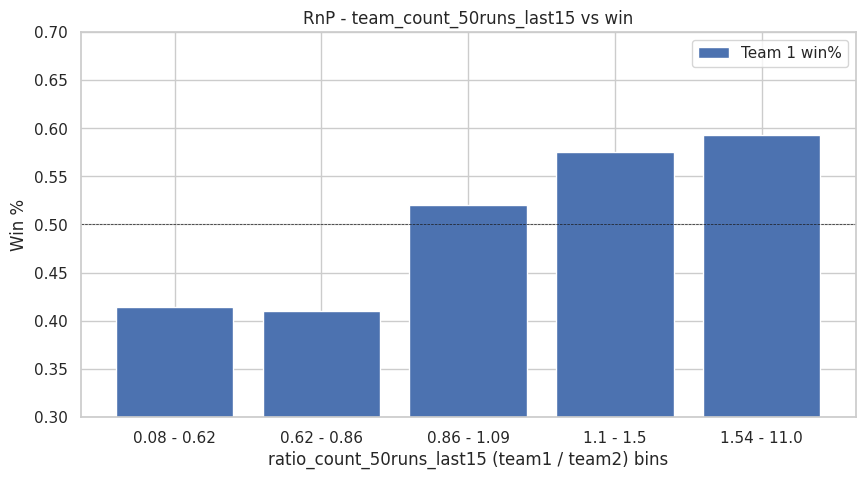

slope: 0.59 / 0.42 =  1.41


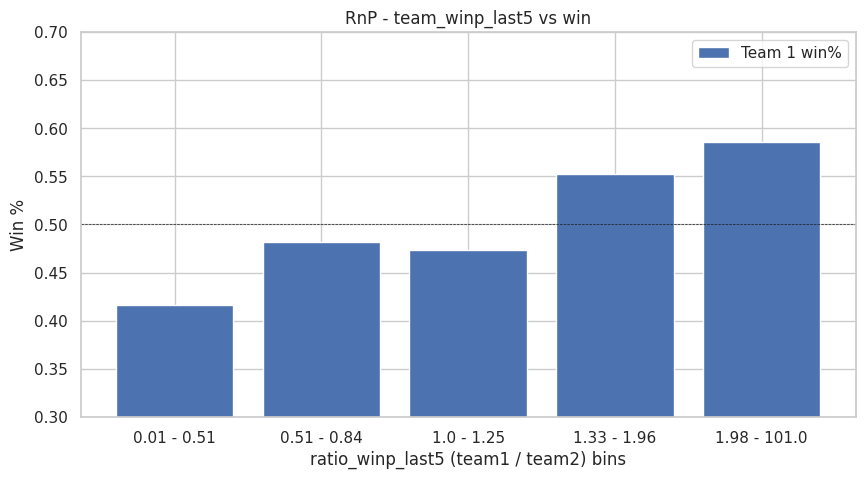

slope: 0.54 / 0.48 =  1.11


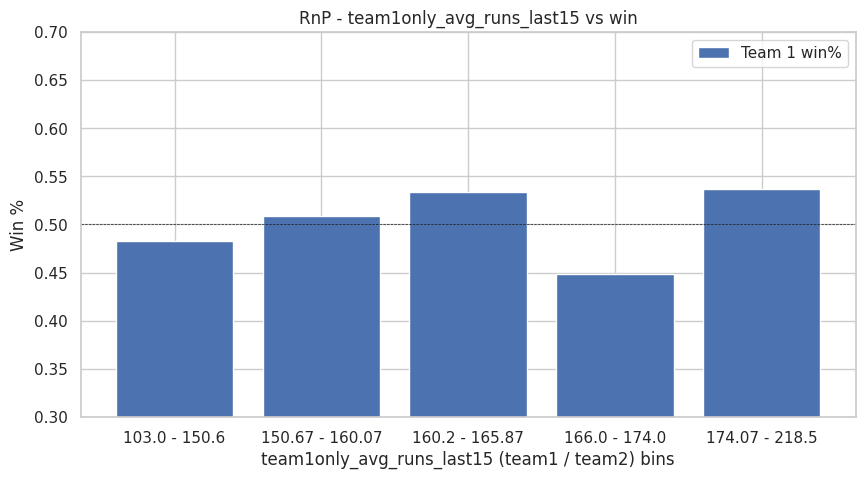

slope: 0.53 / 0.45 =  1.17


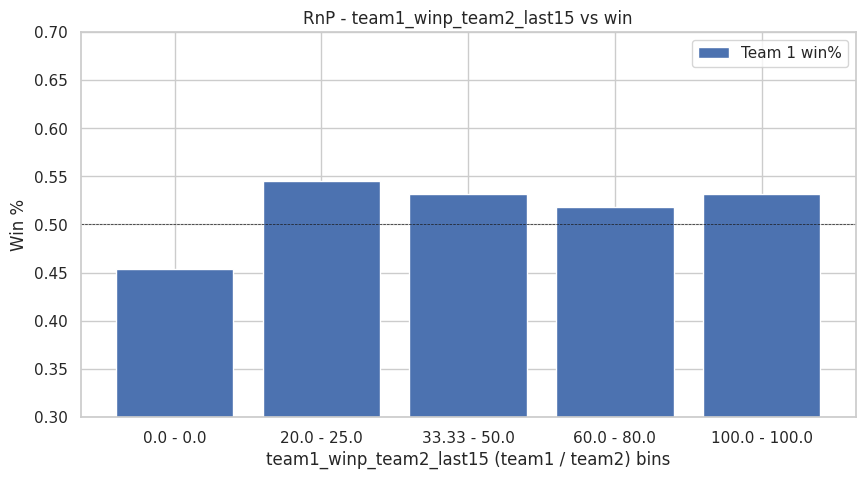

slope: 0.49 / 0.44 =  1.1


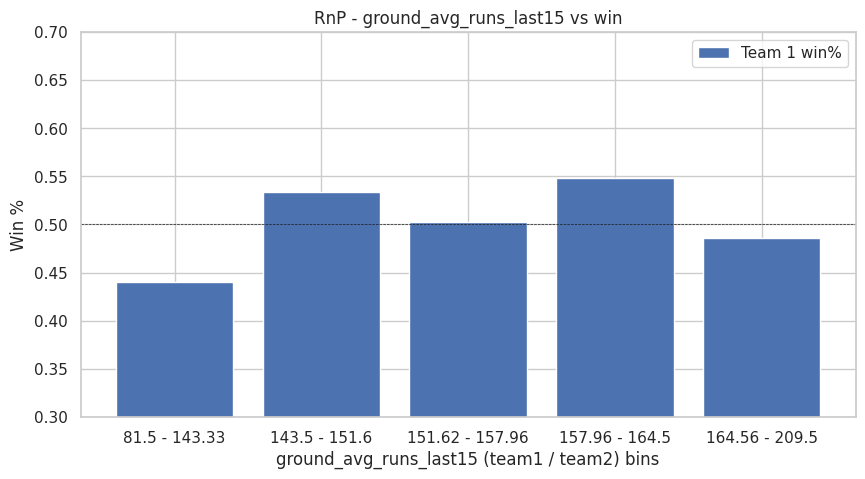

In [32]:
# In[17]:
# RnP of team_count_50runs_last15 computed over the train data. Slope denotes ratio of right most bin to left most bin.
createRnP(train_data, 'team_count_50runs_last15')
createRnP(train_data, 'team_winp_last5')
createRnP(train_data, 'team1only_avg_runs_last15')
createRnP(train_data, 'team1_winp_team2_last15')
createRnP(train_data, 'ground_avg_runs_last15')

In [33]:
# In[19]:
## Doing similar process for test dataset

test_data['team1_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team_count_50runs_last15'] = (test_data['team1_count_50runs_last15'])/(test_data['team2_count_50runs_last15']+1)
test_data.drop(columns=['team1_count_50runs_last15','team2_count_50runs_last15'], inplace=True)
test_data.shape
test_data.head(2)

100%|██████████| 257/257 [00:10<00:00, 24.40it/s]


(257, 21)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,2,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.500
2,9128776,Rn Rs,30428,8058959.0:2162782.0:2981614.0:7833195.0:7556051.0:2486896.0:184960.0:1945397.0:6420126.0:3011735.0:6347494.0,Lw Sr Gs,48334,2654014.0:2954769.0:8058903.0:3479860.0:3299407.0:2275097.0:2740408.0:3865077.0:7924048.0:4859490.0:8228100.0,Rn Rs,bat,Be Sm Mi,Mumbai,2022-05-15,2,In Pr Le,2022,2764,0.842105,0.753086,171.066667,100.00,179.625


In [34]:

# ### 2. team_winp_last5 <br>
#
# Ratio of team1's win % to team2's win % in last 5 games

# In[20]:


def winpLastn(team_id, date, n):
    '''
    Get a team's win % in last n games. If a team has won 3 game out of their last 5, win% is 60%.

    Input-
    1. team_id: ID of the team to get their last n games and winner information from those games.
    2. date: match date from which to get last n historical games.
    3. n: look-back window of games.

    Output- None

    Returns- Float value denoting win% of the team in last n games.
    '''
    # filter out games with either team1/2_id as input team id, match_dt being before current game's date, sort desc by date, and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    win_count = df_rel[df_rel['winner_id']==team_id].shape[0] # count number of rows having winner as the input team
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return win% rounded to two decimal points

In [35]:
def bat_average(player_list, date, n):
    player_list = str(player_list).split(':')
    res_list = []
    for player in player_list:
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        df_rel['Average'] = df_rel['runs'].mean()
        res_list.append(np.nansum(df_rel['Average']))
    return res_list

In [36]:
def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'

    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)

In [37]:
def consistency_bat(player_list, date, n):
    average = bat_average(player_list, date, n)
    player_list = str(player_list).split(':')
    consistency_list = []
    for i in range(len(player_list)):
        df_rel = giveLastNgamesPlayer(player_id=player_list[i], date=date, n=n, bat_or_bowl='bat')
        Avg = average[i]
        innings = len(df_rel)
        strike_rate = df_rel["strike_rate"].mean()
        centuries = len(df_rel[df_rel["runs"] > 100])
        fifties = len(df_rel[df_rel["runs"] > 50])
        zeroes = len(df_rel[df_rel["runs"] == 0])
        consistency_list.append(0.4262*Avg + 0.2566*innings + 0.1510*strike_rate + 0.0787*centuries + 0.0556*fifties - 0.0328*zeroes)
    return np.nansum(consistency_list)

In [38]:
def consistency_bowl(player_list, date, n):
    player_list = str(player_list).split(':')
    consistency_list = []
    for i in range(len(player_list)):
        df_rel = giveLastNgamesPlayer(player_id=player_list[i], date=date, n=n, bat_or_bowl='bowl')
        overs = df_rel["balls_bowled"].sum()/6
        innings = len(df_rel)
        if df_rel["wicket_count"].sum() > 0:
          strike_rate = df_rel["balls_bowled"].sum()/df_rel["wicket_count"].sum()
          Avg = df_rel["runs"].sum()/df_rel["wicket_count"].sum()
        else:
          strike_rate = 0
          Avg = 0
        FF = len(df_rel[df_rel["wicket_count"] > 4])
        consistency_list.append(0.4174*overs + 0.2634*innings + 0.1602*strike_rate + 0.0975*Avg + 0.0615*FF)
    return np.nansum(consistency_list)

In [39]:
import datetime
from dateutil.relativedelta import relativedelta
import math
def form_bat(player_list, date, n):
    average = bat_average(player_list, date, n)
    player_list = str(player_list).split(':')
    consistency_list = []
    for i in range(len(player_list)):
        df = giveLastNgamesPlayer(player_id=player_list[i], date=date, n=n, bat_or_bowl='bat')
        format = '%Y-%m-%d'
        date_ = datetime.datetime.strptime(date, format)
        date_ -= relativedelta(years=1)
        prev_date = date_.strftime('%Y-%m-%d')
        df_rel = df.loc[(df['match_dt'] >= prev_date)]
        Avg = average[i]
        innings = len(df_rel)
        strike_rate = df_rel["strike_rate"].mean()
        centuries = len(df_rel[df_rel["runs"] > 100])
        fifties = len(df_rel[df_rel["runs"] > 50])
        zeroes = len(df_rel[df_rel["runs"] == 0])
        consistency_list.append(0.4262*Avg + 0.2566*innings + 0.1510*strike_rate + 0.0787*centuries + 0.0556*fifties - 0.0328*zeroes)
    return np.nansum(consistency_list)

In [40]:
def form_bowl(player_list, date, n):
    player_list = str(player_list).split(':')
    consistency_list = []
    for i in range(len(player_list)):
        df = giveLastNgamesPlayer(player_id=player_list[i], date=date, n=n, bat_or_bowl='bowl')
        format = '%Y-%m-%d'
        date_ = datetime.datetime.strptime(date, format)
        date_ -= relativedelta(years=1)
        prev_date = date_.strftime('%Y-%m-%d')
        df_rel = df.loc[(df['match_dt'] >= prev_date)]
        overs = df_rel["balls_bowled"].sum()/6
        innings = len(df_rel)
        if df_rel["wicket_count"].sum() > 0:
          strike_rate = df_rel["balls_bowled"].sum()/df_rel["wicket_count"].sum()
          Avg = df_rel["runs"].sum()/df_rel["wicket_count"].sum()
        else:
          strike_rate = 0
          Avg = 0
        FF = len(df_rel[df_rel["wicket_count"] > 4])
        consistency_list.append(0.3269*overs + 0.2846*innings + 0.1877*strike_rate + 0.1210*Avg + 0.0798*FF)
    return np.nansum(consistency_list)

In [41]:
# In[21]:


# Compute team1's win% in last 5 games
train_data['team1_winp_last5'] = train_data.progress_apply(lambda x: \
                                  winpLastn(x['team1_id'], x['match_dt'], 15), axis=1)
# Compute team2's win% in last 5 games
train_data['team2_winp_last5'] = train_data.progress_apply(lambda x: \
                                  winpLastn(x['team2_id'], x['match_dt'], 15), axis=1)

# Compute team1's win% in last 5 games
train_data['team_1_batting_index'] = train_data.progress_apply(lambda x: \
                                  batting_index(x['team1_id'], x['match_dt'], 15), axis=1)
# Compute team2's win% in last 5 games
train_data['team_2_batting_index'] = train_data.progress_apply(lambda x: \
                                  batting_index(x['team2_id'], x['match_dt'], 15), axis=1)

100%|██████████| 880/880 [00:02<00:00, 382.49it/s]


In [42]:
train_data.head()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team1_winp_last5,team2_winp_last5,team_1_batting_index,team_2_batting_index
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,0,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.000000,100.0,157.178571,1,60.00,63.64,0,0
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,0,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.000000,50.0,103.500000,0,60.00,40.00,0,0
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:3681957.0:7671313.0:5320118.0:2922611.0:7184232.0:7661996.0:6240632.0,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:5516720.0:7328110.0:125915.0:130437.0:7507303.0:4420828.0:5652828.0,We,10576,Ne,field,Tt Be Nm,Nottingham,2023-06-02,0,Vy Bt,2023,251,0.857143,0.672131,173.266667,0.0,154.333333,0,40.00,46.67,0,0
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:4690188.0:4739580.0:4739552.0:5744850.0:2294823.0:9266102.0:284339.0,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:5742470.0:2740408.0:3575774.0:3200756.0:334963.0:6399210.0:6347494.0,Ga An Ws,36084,Ga An Ws,bat,Bn La Sm Ta Td,Tarouba,2023-09-10,1,Cn Pr Le,2023,14300,2.166667,1.975610,164.266667,50.0,144.250000,0,60.00,66.67,0,0
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082.0:4640824.0:5038046.0:8180500.0:2035102.0:3851518.0:7881845.0:7453697.0,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:2252452.0:2966879.0:5554254.0:4690230.0:3373285.0:3759846.0:6496482.0,Gt Ts,48341,Gt Ts,field,Pb Ct An IS Ba Sm Mi Ch,Chandigarh,2023-04-13,2,In Pr Le,2023,7118,0.818182,1.327869,164.666667,0.0,189.000000,1,53.33,69.23,0,0


In [43]:

# In[22]:


# Take the ratio of (team1's win% in their last 5 games)/(team2's win% in their last 5 games). Adding 1 to avoid divide by zero error
train_data['team_winp_last5'] = (train_data['team1_winp_last5']+1)/(train_data['team2_winp_last5']+1)
train_data.drop(columns=['team1_winp_last5', 'team2_winp_last5'], inplace=True) # drop intermediate columns


In [44]:

# In[23]:

train_data.shape
train_data.head(2)


(880, 26)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,winner_01,team_1_batting_index,team_2_batting_index
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,0,Sd Mq Ai Ty,2022/23,7398,1.666667,0.943688,139.0,100.0,157.178571,1,0,0
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,0,Ed tr of Wt Is,2021/22,1406,1.285714,1.487805,156.0,50.0,103.500000,0,0,0


In [45]:
# In[24]:


## Similar process for test data

test_data['team1_winp_last5'] = test_data.progress_apply(lambda x: \
            winpLastn(team_id=x['team1_id'], date=x['match_dt'], n=5), axis=1)
test_data['team2_winp_last5'] = test_data.progress_apply(lambda x: \
            winpLastn(team_id=x['team2_id'], date=x['match_dt'], n=5), axis=1)
# Compute team1's win% in last 5 games
test_data['team_1_batting_index'] = test_data.progress_apply(lambda x: \
                                  batting_index(x['team1_roster_ids'], x['match_dt'], 15), axis=1)
# Compute team2's win% in last 5 games
test_data['team_2_batting_index'] = test_data.progress_apply(lambda x: \
                                  batting_index(x['team2_roster_ids'], x['match_dt'], 15), axis=1)

# In[14]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.
train_data['bowler_index_1'] = train_data.progress_apply(lambda x: \
            bowler_index(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

# Computing number of 50 runs in last 15 games for team2 for train dataset.
train_data['bowler_index_2'] = train_data.progress_apply(lambda x: \
            bowler_index(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)



test_data['team_winp_last5'] = (test_data['team1_winp_last5']+1)/(test_data['team2_winp_last5']+1)
test_data.drop(columns=['team1_winp_last5','team2_winp_last5'], inplace=True)
test_data.shape
test_data.head(2)


100%|██████████| 880/880 [00:25<00:00, 33.98it/s]


(257, 23)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_1_batting_index,team_2_batting_index
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,2,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.500,1.319497e+07,1.968280e+07
2,9128776,Rn Rs,30428,8058959.0:2162782.0:2981614.0:7833195.0:7556051.0:2486896.0:184960.0:1945397.0:6420126.0:3011735.0:6347494.0,Lw Sr Gs,48334,2654014.0:2954769.0:8058903.0:3479860.0:3299407.0:2275097.0:2740408.0:3865077.0:7924048.0:4859490.0:8228100.0,Rn Rs,bat,Be Sm Mi,Mumbai,2022-05-15,2,In Pr Le,2022,2764,0.842105,0.753086,171.066667,100.00,179.625,3.839120e+07,3.663431e+07


slope: 0.57 / 0.39 =  1.45


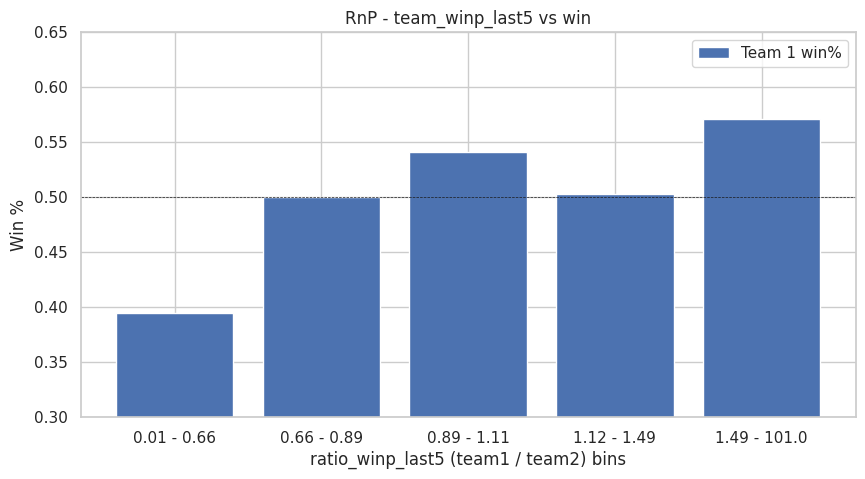

In [46]:
# In[25]:


# RnP of team_winp_last5 computed over the train data.
createRnP(train_data, 'team_winp_last5', ylim_ub=0.65)


In [47]:

# In[26]:


train_data.drop(columns=['winner_01'], inplace=True) # Dropping intermediate column made to plot RnP.



In [48]:
test_data.head()

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_1_batting_index,team_2_batting_index
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,2,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.500,1.319497e+07,1.968280e+07
2,9128776,Rn Rs,30428,8058959.0:2162782.0:2981614.0:7833195.0:7556051.0:2486896.0:184960.0:1945397.0:6420126.0:3011735.0:6347494.0,Lw Sr Gs,48334,2654014.0:2954769.0:8058903.0:3479860.0:3299407.0:2275097.0:2740408.0:3865077.0:7924048.0:4859490.0:8228100.0,Rn Rs,bat,Be Sm Mi,Mumbai,2022-05-15,2,In Pr Le,2022,2764,0.842105,0.753086,171.066667,100.00,179.625,3.839120e+07,3.663431e+07
3,9586919,Ja Ts,36098,4690258.0:8464385.0:1613898.0:5744780.0:3150720.0:4690104.0:1594319.0:5509524.0:2036649.0:3023383.0:5471948.0,St La Ks,36112,2331475.0:313809.0:391103.0:2742837.0:2097017.0:7921535.0:7459647.0:8464343.0:4690230.0:8339701.0:4702774.0,St La Ks,field,Dn Sy Nl Ct Sm Gs It St La,Gros Islet,2023-08-16,2,Cn Pr Le,2023,11892,0.285714,1.487805,166.000000,75.00,155.500,9.742600e+06,3.738749e+07
4,9128538,Ci Sr Ks,30414,7422673.0:249087.0:62432.0:232000.0:5001170.0:1642738.0:196580.0:360086.0:2022957.0:7968225.0:7879829.0,Gt Ts,48341,1958683.0:7491224.0:3339160.0:5452754.0:2252452.0:2966879.0:5554254.0:4690230.0:3456424.0:3373285.0:8118053.0,Gt Ts,field,Ma Ct An Sm Pe,Pune,2022-04-17,2,In Pr Le,2022,18752,2.375000,0.310330,169.933333,0.00,164.125,3.355168e+07,1.695680e+07
5,9516653,Pb Ks,30407,8127181.0:197658.0:4239038.0:2827327.0:5053082.0:4640824.0:5038046.0:8180500.0:2035102.0:7453697.0:7881845.0:5788418.0,Mi Is,30435,238727.0:5043310.0:7537004.0:3125562.0:6249256.0:8191868.0:8058924.0:230775.0:4688998.0:8118914.0:8713270.0:8442286.0,Mi Is,field,Pb Ct An IS Ba Sm Mi Ch,Chandigarh,2023-05-03,2,In Pr Le,2023,7118,0.400000,0.672131,177.066667,50.00,184.500,1.880885e+07,3.075874e+07


In [49]:

# ### 3. teamonly_avg_runs_last15 <br>
# team1's avg inning runs in last 15 games

# In[27]:


## derived feature computed using toss winner & toss decision to denote the inning team1 bats.
# If team1 won the toss and chose to bat or team2 won the toss and chose to bowl, the feature takes the value 1, else 2.
match_lvl_data['team1_bat_inning'] = np.where( ((match_lvl_data['team1']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='bat'))|\
                                               ((match_lvl_data['team2']==match_lvl_data['toss winner'])&(match_lvl_data['toss decision']=='field')) , 1, 2)


In [50]:
# In[28]:

match_lvl_data.head(2)

,match id,team1,team2,winner,by,win amount,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,umpire1,umpire2,inning1_runs,inning1_wickets,inning1_balls,inning2_runs,inning2_wickets,inning2_balls,team1_id,team1_roster_ids,team2_id,team2_roster_ids,series_type,winner_id,player_of_the_match_id,team1_bat_inning
0,8638034,Nn Ds,Wn,Wn,wickets,9.0,Wn,field,By Ol,Mount Maunganui,2021-01-01,night match,Sr Sh,2020/21,17681,Dn Mw,TJ Pe,148,6,130,152.0,1.0,97.0,17982,7907451.0:4381761.0:31464.0:258649.0:4949790.0:3834305.0:3776849.0:6718340.0:3566240.0:4950364.0:7543647.0,18570,2653993.0:6718326.0:6718382.0:2486896.0:2288789.0:4950224.0:8187878.0:3083667.0:4950294.0:6718396.0:1585464.0,other_domestic,18570,NaN,1
1,8588005,Me Rs,Sy Tr,Sy Tr,runs,7.0,Sy Tr,field,Ca Ol,Carrara,2021-01-01,night match,Bg Bh Le,2020/21,6663,D Tr,PJ Ge,166,6,106,117.0,2.0,74.0,33942,37351.0:46794.0:5406540.0:2231928.0:181404.0:1594319.0:7534687.0:7537067.0:1905847.0:8339701.0:7620346.0,33963,1506098.0:1749075.0:36665.0:2083409.0:7534652.0:5788320.0:1612610.0:5509524.0:5497274.0:3876613.0:8193310.0,other_domestic,33963,1749075.0,1


In [51]:
# In[29]:


def teamAvgRunsLastn(team_id, date, n):
    '''
    Function to calculate a team's average runs in their last n games.

    Input-
    1. team_id: ID of the team to calculate average runs.
    2. date: match date of the current game for which the feature is calculated.
    3. n: look-back window of games for the team.

    Output- None

    Return- Float value denoting average of runs scored by team1 in their last n games.
    '''
    # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    # combine two dataframes - one where input team is batting first, and another one where input team is batting second.
    df_rel = pd.concat([ df_rel[df_rel['team1_bat_inning']==1][['inning1_runs']].rename(columns={'inning1_runs':'runs'}), \
                         df_rel[df_rel['team1_bat_inning']==2][['inning2_runs']].rename(columns={'inning2_runs':'runs'}) ] )
    return df_rel['runs'].mean() # return mean of the combined dataframe.


In [52]:
# In[30]:


# Compute average runs scored by team1 in their last 15 games for train data.
train_data['team1only_avg_runs_last15'] = train_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)



100%|██████████| 880/880 [00:03<00:00, 237.15it/s]


In [53]:

# In[31]:


# Similarly for test data.
test_data['team1only_avg_runs_last15'] = test_data.progress_apply(lambda x: \
            teamAvgRunsLastn(x['team1_id'], x['match_dt'], 15), axis=1)
test_data.shape
test_data.head(2)


100%|██████████| 257/257 [00:01<00:00, 230.01it/s]


(257, 23)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_1_batting_index,team_2_batting_index
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,2,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.500,1.319497e+07,1.968280e+07
2,9128776,Rn Rs,30428,8058959.0:2162782.0:2981614.0:7833195.0:7556051.0:2486896.0:184960.0:1945397.0:6420126.0:3011735.0:6347494.0,Lw Sr Gs,48334,2654014.0:2954769.0:8058903.0:3479860.0:3299407.0:2275097.0:2740408.0:3865077.0:7924048.0:4859490.0:8228100.0,Rn Rs,bat,Be Sm Mi,Mumbai,2022-05-15,2,In Pr Le,2022,2764,0.842105,0.753086,171.066667,100.00,179.625,3.839120e+07,3.663431e+07


In [54]:


# In[32]:


train_data.shape
train_data.head(2)


(880, 27)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_1_batting_index,team_2_batting_index,bowler_index_1,bowler_index_2
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,0,Sd Mq Ai Ty,2022/23,7398,1.666667,0.943688,139.0,100.0,157.178571,0,0,4.999024e+06,1.999463e+06
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,0,Ed tr of Wt Is,2021/22,1406,1.285714,1.487805,156.0,50.0,103.500000,0,0,5.998505e+06,6.998351e+06


In [55]:


# ### 4. teamone_winp_teamtwo_last15 <br>
# Team1's win percentage againts Team2 in last 15 games

# In[33]:


def winpCrossLastn(team1_id, team2_id, date, n):
    '''
    Function to compute team1's win% against team2 from the current game in their past n encounters.

    Input-
    1. team1_id: ID of team1 to calculate win% of.
    2. team2_id: ID of team2 to calculate win% against.
    3: date: match date of the current game for which the feature is to be calculated.
    4. n: look-back window of games for both these teams.

    Output- None

    Returns- Float value denoting team1's win% against team2 in their past n games against each other.
    '''
    # filter out games where either team1_id is input team1 and team2_id is input team2, or where team2_id is input team1 and team1_id is input team2.
    # Also, match date is less than current games's input date, sort desc by date and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      (((match_lvl_data['team1_id']==team1_id)&(match_lvl_data['team2_id']==team2_id))|((match_lvl_data['team1_id']==team2_id)&(match_lvl_data['team2_id']==team1_id)))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    win_count = df_rel[df_rel['winner_id']==team1_id].shape[0] # Counting number of rows (games) where winner is input team1.
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return Float denoting team1's win% against team2 in past n games rounded to 2 decimal places.


In [56]:


# In[34]:


# Compute team1 win% against team2 in their past 15 encounters for train data.
train_data['team1_winp_team2_last15'] = train_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 5), axis=1)


100%|██████████| 880/880 [00:01<00:00, 478.64it/s]


In [57]:


# In[35]:


train_data.shape
train_data.head(2)

(880, 27)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_1_batting_index,team_2_batting_index,bowler_index_1,bowler_index_2
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,0,Sd Mq Ai Ty,2022/23,7398,1.666667,0.943688,139.0,100.0,157.178571,0,0,4.999024e+06,1.999463e+06
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,0,Ed tr of Wt Is,2021/22,1406,1.285714,1.487805,156.0,50.0,103.500000,0,0,5.998505e+06,6.998351e+06


In [58]:

# In[36]:


# Similarly for test data.
test_data['team1_winp_team2_last15'] = test_data.progress_apply(lambda x: \
                                  winpCrossLastn(x['team1_id'], x['team2_id'], x['match_dt'], 5), axis=1)

100%|██████████| 257/257 [00:00<00:00, 452.84it/s]


In [59]:

# In[37]:


test_data.shape
test_data.head(2)



(257, 23)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_1_batting_index,team_2_batting_index
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,2,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.500,1.319497e+07,1.968280e+07
2,9128776,Rn Rs,30428,8058959.0:2162782.0:2981614.0:7833195.0:7556051.0:2486896.0:184960.0:1945397.0:6420126.0:3011735.0:6347494.0,Lw Sr Gs,48334,2654014.0:2954769.0:8058903.0:3479860.0:3299407.0:2275097.0:2740408.0:3865077.0:7924048.0:4859490.0:8228100.0,Rn Rs,bat,Be Sm Mi,Mumbai,2022-05-15,2,In Pr Le,2022,2764,0.842105,0.753086,171.066667,100.00,179.625,3.839120e+07,3.663431e+07


In [60]:
# ### 5. ground_avg_runs_last15 <br>
# average runs scored in the ground in last 15 games

# In[38]:


def avgRunsGround(ground_id, date, n):
    '''
    Function to calculate average runs scored in ground/venue.

    Input-
    1. ground_id: ID of the ground to calculate the feature for.
    2. date: match date of the current game to calculate the feature for.
    3. n: look-back window of games for the ground.

    Output- None

    Returns- Average runs scored in the ground.
    '''
    # filter out games with ground_id being the input ground_id and date earlier than current game's input date. Sort desc by date, and select top n rows (games).
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&(match_lvl_data['ground_id']==ground_id)].sort_values(by='match_dt', ascending=False).head(n)
    df_rel['avg_runs_inn'] = (df_rel['inning1_runs']+df_rel['inning2_runs'])/2 # take the mean of inning1_runs and inning2_runs in a separate column.
    return df_rel['avg_runs_inn'].mean() # Return the mean value of the computed column above.


In [61]:
# In[39]:


## Calculate average runs in the ground for last 15 games hosted in that venue for train data.
train_data['ground_avg_runs_last15'] = train_data.progress_apply(lambda x: \
                                  avgRunsGround(x['ground_id'], x['match_dt'], 15), axis=1)
## Similarly for test data.
test_data['ground_avg_runs_last15'] = test_data.progress_apply(lambda x: \
                                  avgRunsGround(x['ground_id'], x['match_dt'], 15), axis=1)



100%|██████████| 257/257 [00:00<00:00, 413.64it/s]


In [62]:

# In[40]:


train_data.shape
train_data.head(2)

(880, 27)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_1_batting_index,team_2_batting_index,bowler_index_1,bowler_index_2
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,0,Sd Mq Ai Ty,2022/23,7398,1.666667,0.943688,139.0,100.0,157.178571,0,0,4.999024e+06,1.999463e+06
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,0,Ed tr of Wt Is,2021/22,1406,1.285714,1.487805,156.0,50.0,103.500000,0,0,5.998505e+06,6.998351e+06


In [63]:


# In[41]:


test_data.shape
test_data.head(2)


(257, 23)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,team_1_batting_index,team_2_batting_index
1,9262189,Ga An Ws,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188.0:4739552.0:4690328.0:5744850.0:4739580.0:9266102.0:284339.0,Ja Ts,36098,4690258.0:3761246.0:8464385.0:5742470.0:3150720.0:4690104.0:181404.0:1594319.0:5509524.0:4239794.0:2036649.0,Ja Ts,field,Pe Sm Ga,Providence,2022-09-21,2,Cn Pr Le,2022,13915,0.615385,0.344262,151.285714,66.67,153.500,1.319497e+07,1.968280e+07
2,9128776,Rn Rs,30428,8058959.0:2162782.0:2981614.0:7833195.0:7556051.0:2486896.0:184960.0:1945397.0:6420126.0:3011735.0:6347494.0,Lw Sr Gs,48334,2654014.0:2954769.0:8058903.0:3479860.0:3299407.0:2275097.0:2740408.0:3865077.0:7924048.0:4859490.0:8228100.0,Rn Rs,bat,Be Sm Mi,Mumbai,2022-05-15,2,In Pr Le,2022,2764,0.842105,0.753086,171.066667,100.00,179.625,3.839120e+07,3.663431e+07


In [64]:
# ## Save

# In[57]:

# train_data.to_csv('train_data_with_samplefeatures', index=False)
# test_data.to_csv('test_data_with_samplefeatures', index=False)



In [65]:
#!/usr/bin/env python
# coding: utf-8
# In[1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [66]:

## Load libraries
import pandas as pd
import numpy as np


In [67]:
pd.set_option('display.max_columns',50)

In [145]:
train_data = pd.read_csv('/content/drive/MyDrive/AMEX/train_data_with_samplefeatures.csv')
test_data = pd.read_csv('/content/drive/MyDrive/AMEX/667a986f0b981_r2_data_with_samplefeatures.csv')


In [146]:

nan_count_per_column = train_data.isna().sum()
print("\nTotal NaN values per column:\n", nan_count_per_column)


Total NaN values per column:
 match id                     0 
team1                        0 
team1_id                     0 
team1_roster_ids             0 
team2                        0 
team2_id                     0 
team2_roster_ids             0 
winner                       0 
winner_id                    0 
toss winner                  0 
toss decision                0 
venue                        0 
city                         0 
match_dt                     0 
lighting                     0 
series_name                  0 
season                       0 
ground_id                    0 
team_count_50runs_last15     0 
team_winp_last5              0 
team1only_avg_runs_last15    21
team1_winp_team2_last15      0 
ground_avg_runs_last15       53
dtype: int64


In [134]:
train_data.shape
train_data.head(2)


(948, 23)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:3299407.0:232000.0:7883504.0:8725723.0:7878989.0:2526390.0:8725730.0:4017523.0,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:3698337.0:5058192.0:6844718.0:4566526.0:6596582.0:4161975.0:7952804.0:8465057.0,Hl Ph,12634,Hl Ph,field,Hr Ct Sm Ie,Indore,2022-10-20,day/night match,Sd Mq Ai Ty,2022/23,7398,1.666667,0.672131,139.0,100.0,157.178571
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409.0:172199.0:2022957.0:1482998.0:1711492.0:4507208.0:3231437.0,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:1613926.0:2740408.0:4739552.0:5744850.0:4690104.0:3715697.0:3468870.0,Ed,20,Wt Is,field,Kn Ol Bn Bs,Bridgetown,2022-01-23,day/night match,Ed tr of Wt Is,2021/22,1406,1.285714,1.952381,156.0,50.0,103.500000


In [136]:
test_data.shape
test_data.head(2)

(197, 21)

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,city,match_dt,lighting,series_name,season,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15
0,9272619,Me Ss,33949,4003390.0:7960994.0:3901078.0:2669316.0:3737103.0:5469092.0:1829491.0:5419532.0:4012203.0:6308098.0:2656541.0,Ht Hs,33928,5843200.0:4223883.0:4655384.0:6249256.0:2161599.0:3459623.0:8497866.0:4767832.0:4238975.0:5788418.0:6732004.0,Ht Hs,field,Be Ol Ht,Hobart,2023-01-09,night match,Bg Bh Le,2022/23,6348,0.666667,1.000000,167.933333,60.0,154.115385
1,9086958,Na,209,5836452.0:8246468.0:7500324.0:3065502.0:3633503.0:3377359.0:1547993.0:3876760.0:4176661.0:2311574.0:7488753.0,Si La,69,7200598.0:4403531.0:3260564.0:2420760.0:2398346.0:3061225.0:5490666.0:4365878.0:5786836.0:3865077.0:7968225.0,Si La,field,GA Sm Sh Gg Va,Geelong,2022-10-16,day/night match,Si La tr of Aa,2022/23,3961,0.142857,0.207921,141.888889,0.0,142.833333


In [147]:
train_data['winner_01'] = train_data.apply(lambda x: 1 if (x['team2']==x['winner']) else 0, axis=1)

In [148]:

# #### Pre process

# In[8]:
## Toss winner to numerical - 1 if team2 wins, else 0

train_data['toss_winner_01'] = np.where(train_data['toss winner']==train_data['team2'], 1, 0)
test_data['toss_winner_01'] = np.where(test_data['toss winner']==test_data['team2'], 1, 0)


In [139]:
# In[9]:


## Toss decision - categorical - 1 if winner bats, 0 otherwise


test_data['toss_decision_01'] = np.where(test_data['toss decision']=='bat', 1, 0)

train_data['chase'] = np.where(((train_data['toss_winner_01'] == 1) & (train_data['toss_decision_01'] == 1)) | ((train_data['toss_winner_01'] == 0) & (train_data['toss_decision_01'] == 0)) , 1, 0)
test_data['chase'] = np.where(((test_data['toss_winner_01'] == 1) & (test_data['toss_decision_01'] == 1)) |((test_data['toss_winner_01'] == 0) & (test_data['toss_decision_01'] == 0)) , 1, 0)
# Compute team1's win% in last 5 games
train_data['team_1_batting_index'] = train_data.progress_apply(lambda x: \
                                  batting_index(x['team1_roster_ids'], x['match_dt'], 15), axis=1)
# Compute team2's win% in last 5 games
train_data['team_2_batting_index'] = train_data.progress_apply(lambda x: \
                                  batting_index(x['team2_roster_ids'], x['match_dt'], 15), axis=1)

# Compute team1's win% in last 5 games
test_data['team_1_batting_index'] = test_data.progress_apply(lambda x: \
                                  batting_index(x['team1_roster_ids'], x['match_dt'], 15), axis=1)
# Compute team2's win% in last 5 games
test_data['team_2_batting_index'] = test_data.progress_apply(lambda x: \
                                  batting_index(x['team2_roster_ids'], x['match_dt'], 15), axis=1)
# In[14]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.










100%|██████████| 197/197 [00:09<00:00, 20.63it/s]


In [149]:
# train_data['bowler_index_1'] = train_data.progress_apply(lambda x: \
#             bowler_index(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

# # Computing number of 50 runs in last 15 games for team2 for train dataset.
# train_data['bowler_index_2'] = train_data.progress_apply(lambda x: \
#             bowler_index(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

# In[14]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.

test_data['bowler_index_1'] = test_data.progress_apply(lambda x: \
            bowler_index(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

# Computing number of 50 runs in last 15 games for team2 for train dataset.
test_data['bowler_index_2'] = test_data.progress_apply(lambda x: \
            bowler_index(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


100%|██████████| 207/207 [00:07<00:00, 27.71it/s]


In [ ]:

# # CONSISTENCY BAT
# train_data['consistency_bat_1'] = train_data.progress_apply(lambda x: \
#             consistency_bat(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

# # Computing number of 50 runs in last 15 games for team2 for train dataset.
# train_data['consistency_bat_2'] = train_data.progress_apply(lambda x: \
#             consistency_bat(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['consistency_bat_1'] = test_data.progress_apply(lambda x: \
            consistency_bat(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

# Computing number of 50 runs in last 15 games for team2 for train dataset.
test_data['consistency_bat_2'] = test_data.progress_apply(lambda x: \
            consistency_bat(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

# In[14]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.



 90%|█████████ | 187/207 [00:17<00:01, 11.09it/s]

In [ ]:
# # CONSISTENCY BOWL
# train_data['consistency_bowl_1'] = train_data.progress_apply(lambda x: \
#             consistency_bowl(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

# # Computing number of 50 runs in last 15 games for team2 for train dataset.
# train_data['consistency_bowl_2'] = train_data.progress_apply(lambda x: \
#             consistency_bowl(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)


test_data['consistency_bowl_1'] = test_data.apply(lambda x: \
            consistency_bowl(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

# Computing number of 50 runs in last 15 games for team2 for train dataset.
test_data['consistency_bowl_2'] = test_data.apply(lambda x: \
            consistency_bowl(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

In [ ]:
# # FORM BAT
# train_data['form_bat_1'] = train_data.progress_apply(lambda x: \
#             form_bat(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

# # Computing number of 50 runs in last 15 games for team2 for train dataset.
# train_data['form_bat_2'] = train_data.progress_apply(lambda x: \
#             form_bat(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

# In[14]:
# Computing number of 50 runs in last 15 games for team1 for train dataset.

test_data['form_bat_1'] = test_data.apply(lambda x: \
            form_bat(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

# Computing number of 50 runs in last 15 games for team2 for train dataset.
test_data['form_bat_2'] = test_data.apply(lambda x: \
            form_bat(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)





In [ ]:
# # FORM BOWL
# train_data['form_bowl_1'] = train_data.progress_apply(lambda x: \
#             form_bowl(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

# # Computing number of 50 runs in last 15 games for team2 for train dataset.
# train_data['form_bowl_2'] = train_data.progress_apply(lambda x: \
#             form_bowl(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['form_bowl_1'] = test_data.apply(lambda x: \
            form_bowl(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

# Computing number of 50 runs in last 15 games for team2 for train dataset.
test_data['form_bowl_2'] = test_data.apply(lambda x: \
            form_bowl(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

In [ ]:
train_data.head()

In [ ]:
test_data.head()

In [ ]:
def encode_lighting_value(value):
    if value == 'day/night match':
        return 0
    elif value == 'day match':
        return 1
    elif value == 'night match':
        return 2

train_data['lighting'] = train_data['lighting'].apply(encode_lighting_value)
test_data['lighting'] = test_data['lighting'].apply(encode_lighting_value)


# #### Selecting relevant columns

# In[10]:
from sklearn.model_selection import train_test_split

X,y = train_data[['toss_winner_01','toss_decision_01','team_count_50runs_last15','team_winp_last5','team1only_avg_runs_last15','team1_winp_team2_last15','ground_avg_runs_last15','lighting','team_1_batting_index','team_2_batting_index','bowler_index_1','bowler_index_2','consistency_bat_1','consistency_bat_2','consistency_bowl_1','consistency_bowl_2','form_bat_1','form_bat_2','form_bowl_1','form_bowl_2']], train_data['winner_01']
# X_temp=X
# y_temp=y

# x_train_data1, x_train_data2, y_train_data1, y_train_data2 = train_test_split(X, y, test_size=0.10, random_state=42)


In [ ]:

X_test = test_data[X.columns.tolist()]
# X_temp_test=X_test
# X=x_train_data1
# y=y_train_data1
# X_test=x_train_data2
# Y_test=y_train_data2

In [ ]:


# #### Imputation

# In[12]:


# X_nans = X.isna().sum().reset_index()
# X_nans[X_nans[0]!=0]

# X_test_nans = X_test.isna().sum().reset_index()
# X_test_nans[X_test_nans[0]!=0]



In [ ]:


X.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)





In [ ]:

X['toss_winner_01'].value_counts()
X['toss_decision_01'].value_counts()
X['team_count_50runs_last15'].describe()


In [ ]:

from sklearn.ensemble import GradientBoostingClassifier


# In[17]:


# user-defined parameters

algo_name = 'XGBClassifier'
is_ensemble = 'no'
n_trees = 14
depth = 4
lr = 0.2

In [ ]:
# ##### Train

# In[18]:


clf_gbm = GradientBoostingClassifier(n_estimators = n_trees, max_depth = depth, learning_rate = lr).fit(X,y)

In [ ]:
y_gbm_predict=clf_gbm.predict(X)
train_data['y_pred_01'] = y_gbm_predict

test_data['y_pred_01'] = clf_gbm.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

# Train accuracy
print(classification_report(y, y_gbm_predict, labels=[0,1]))

In [ ]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(objective='binary', n_estimators=10, max_depth = depth,force_col_wise='true')
lgb_model.fit(X, y)
y_LGB_predict = lgb_model.predict(X_test)
print(classification_report(Y_test, lgb_model.predict(X_test), labels=[0,1]))



In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(
    n_estimators=14,
    max_depth=depth,
    learning_rate=0.20,

)
xgb_model.fit(X, y)
y_xgb_predict = xgb_model.predict(X_test)
print(classification_report(Y_test, y_xgb_predict, labels=[0,1]))
train_data['y_pred_01'] = xgb_model.predict(X_temp)
test_data['y_pred_01'] = clf_gbm.predict(X_temp_test)

Ensemble of GBM and LightGBM

In [ ]:
ensembled_prediction = np.around((0.2*y_gbm_predict)+(0.2*y_LGB_predict)+(0.6*y_xgb_predict))
print(classification_report(Y_test, ensembled_prediction, labels=[0,1]))

In [ ]:

import catboost as cat
from catboost import CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=10,
    depth=depth,
    learning_rate=0.2,
    loss_function='CrossEntropy',
    custom_metric=['AUC']
)
catboost_model.fit(X, y)
y_catboost_predict = catboost_model.predict(X_test)
print(classification_report(Y_test, y_catboost_predict, labels=[0,1]))


In [ ]:
train_data.head()

In [ ]:

train_data['win_pred_score'] = clf_gbm.predict_proba(X)[:,1]
test_data['win_pred_score'] = clf_gbm.predict_proba(X_test)[:,1]

In [ ]:

# ##### Getting win_pred_score corresponding to winner team

# In[23]:


train_data['win_pred_score'] = np.where( (train_data['y_pred_01']==0), (1-train_data['win_pred_score']), train_data['win_pred_score'])
test_data['win_pred_score'] = np.where( (test_data['y_pred_01']==0), (1-test_data['win_pred_score']), test_data['win_pred_score'])


In [ ]:


# ##### Getting winner_team_id from custom dependent column

# In[24]:


train_data['win_pred_team_id'] = np.where( (train_data['y_pred_01']==0), (train_data['team1_id']), train_data['team2_id'])
test_data['win_pred_team_id'] = np.where( (test_data['y_pred_01']==0), (test_data['team1_id']), test_data['team2_id'])


In [ ]:


# #### Feature importance

# In[25]:


df_feat_importance = pd.DataFrame({'feat_name':X.columns.tolist(), 'model_feat_imp_train':clf_gbm.feature_importances_}).sort_values(by='model_feat_imp_train', ascending=False)\
                                                                                                                        .reset_index(drop=True).head(10)
df_feat_importance


In [ ]:


# ## File preparation

# #### File 1

# In[26]:


train_data['dataset_type'] = 'train'
test_data['dataset_type'] = 'r2'

In [ ]:


## refactor

df_file1 =test_data[['match id','dataset_type','win_pred_team_id','win_pred_score',] + list(df_feat_importance['feat_name'].head(10))]

renaming_dict = {}
for i,col in enumerate(list(df_feat_importance['feat_name'].head(10))):
    renaming_dict[col] = f'indep_feat_id{i+1}'
df_file1.rename(columns=renaming_dict, inplace=True)

for i in range(1,11):
    if f'indep_feat_id{i}' not in df_file1.columns:
        df_file1[f'indep_feat_id{i}'] = np.nan

df_file1['train_algorithm'] = algo_name
df_file1['is_ensemble'] = is_ensemble
df_file1['train_hps_trees'] = n_trees
df_file1['train_hps_depth'] = depth
df_file1['train_hps_lr'] = lr



In [ ]:

df_file1.shape
df_file1.head()


In [ ]:


# #### File 2

# In[29]:


feature_desc = {'team_count_50runs_last15':'Ratio of number of 50s by players in team1 to number of 50s by players in team2 in last 15 games',\
               'team_winp_last5':'Ratio of team1\'s win % to team2\'s win % in last 5 games',\
               'ground_avg_runs_last15':'average runs scored in the ground in last 15 games',\
               'team1_winp_team2_last15':'Team1\'s win percentage against Team2 in last 15 games',\
               'team1only_avg_runs_last15':'team1\'s avg inning runs in last 15 games',\

               'season_num' : 'Numerical form of season. Takes 1 for oldest season and increases for latest seasons.',\
               'toss_winner_01' : 'Toss winner to numerical - 1 if team2 wins, else 0',\
               'toss_decision_01' : 'Toss decision - categorical - 1 if winner bats, 0 otherwise',\
                'team_1_batting_index':'A rating given to batsmen according to his performance',\
                'team_2_batting_index':'A rating given to batsmen according to his performance',\
                'bowler_index_1':'A rating given to bowler according to his performance',\
                'bowler_index_2':'A rating given to bowler according to his performance',\
                'consistency_bat_1':'This attribute describes how experienced the player is and how consistent he has been throughout his career.',\
                'consistency_bat_2':'This attribute describes how experienced the player is and how consistent he has been throughout his career.',\
                'consistency_bowl_1':'This attribute describes how experienced the player is and how consistent he has been throughout his career.',\
                'consistency_bowl_2':'This attribute describes how experienced the player is and how consistent he has been throughout his career.',\
                'form_bat_1':'Form of a player describes his performance over last one year',\
                'form_bat_2':'Form of a player describes his performance over last one year',\
                'form_bowl_1':'Form of a player describes his performance over last one year',\
                'form_bowl_2':'Form of a player describes his performance over last one year',\

                }



In [ ]:

# In[30]:


# df_feat_importance.rename(index={0:'feat_id'}, inplace=True)
df_file2 = df_feat_importance
df_file2['feat_id'] = [i+1 for i in df_file2.index]
df_file2['feat_rank_train'] = [i+1 for i in df_file2.index]
df_file2 = df_file2.set_index('feat_id')
df_file2['feat_description'] = df_file2['feat_name'].map(feature_desc)


In [ ]:
# In[31]:


df_file2

In [ ]:
# @title model_feat_imp_train

from matplotlib import pyplot as plt
df_file2['model_feat_imp_train'].plot(kind='hist', bins=20, title='model_feat_imp_train')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# ## Save

# In[ ]:

df_file1.to_csv('file1.csv', index=False)
df_file2.to_csv('file2.csv')
